# Main figures and tables

## Figure2_VariantConcordance

(14473, 64)
(14694, 64)
(12415, 128)
0.9316924568911332
0.9705283597636676
0.9598567858586543


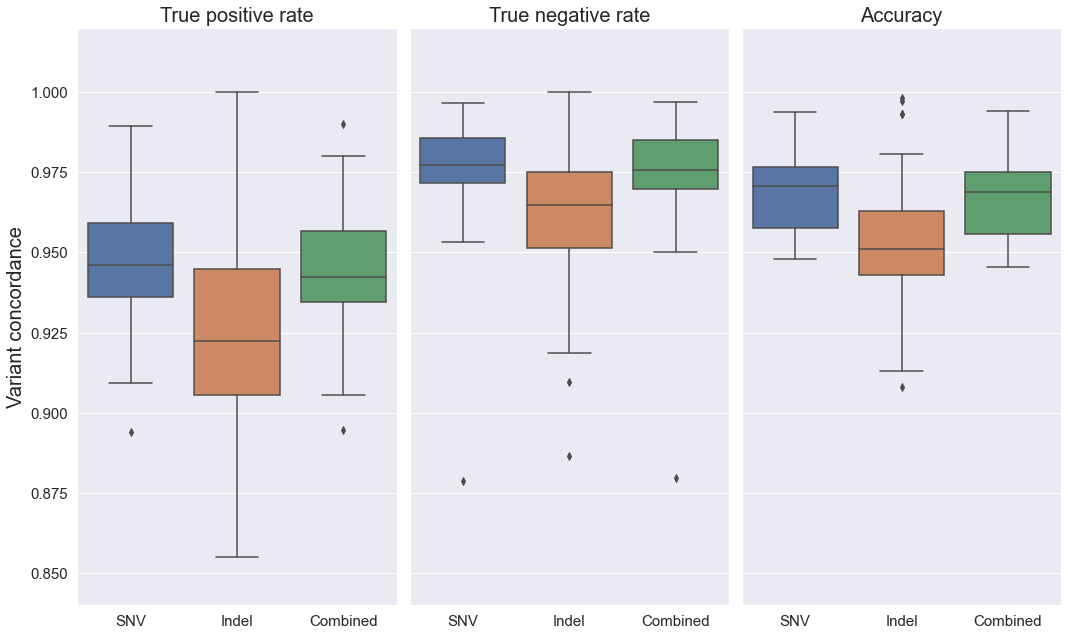

In [3]:
import pandas as pd
import numpy as np
from fuc import pyvcf, common
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

ts_vf = pyvcf.VcfFrame.from_file('other-files/ts.merged.joint.filtered.vcf')

wgs_vf = pyvcf.VcfFrame.from_file('other-files/wgs.merged.joint.filtered.vcf')
wgs_vf = wgs_vf.update_chr_prefix(mode='add')

merged_vf = pyvcf.merge([ts_vf, wgs_vf])
merged_vf = merged_vf.filter_multialt()
merged_vf = merged_vf.unphase()
merged_vf = merged_vf.filter_bed('other-files/PharmSeq_v1.0.bed')

df = pd.read_table('other-files/wgs-mapping.txt', names=['WGS', 'TS'])
# df = df[df.TS != 'TS2_NA18973'] # Incorrect sample (i.e. TS2_NA18973 is not NA18973)

all_tpr = []
all_tnr = []
all_acc = []

snv_tpr = []
snv_tnr = []
snv_acc = []

indel_tpr = []
indel_tnr = []
indel_acc = []

for i, r in df.iterrows():
    all_results = common.sumstat(*merged_vf.calculate_concordance(r.TS, r.WGS, mode='all'))
    all_tpr.append(all_results['tpr'])
    all_tnr.append(all_results['tnr'])
    all_acc.append(all_results['acc'])

    snv_results = common.sumstat(*merged_vf.calculate_concordance(r.TS, r.WGS, mode='snv'))
    snv_tpr.append(snv_results['tpr'])
    snv_tnr.append(snv_results['tnr'])
    snv_acc.append(snv_results['acc'])
    
    indel_results = common.sumstat(*merged_vf.calculate_concordance(r.TS, r.WGS, mode='indel'))
    indel_tpr.append(indel_results['tpr'])
    indel_tnr.append(indel_results['tnr'])
    indel_acc.append(indel_results['acc'])
    
tpr_dict = {'SNV': snv_tpr, 'Indel': indel_tpr, 'Combined': all_tpr}
tnr_dict = {'SNV': snv_tnr, 'Indel': indel_tnr, 'Combined': all_tnr}
acc_dict = {'SNV': snv_acc, 'Indel': indel_acc, 'Combined': all_acc}

tpr_df = pd.DataFrame(tpr_dict).melt()
tnr_df = pd.DataFrame(tnr_dict).melt()
acc_df = pd.DataFrame(acc_dict).melt()

fig, axes = plt.subplots(1, 3, figsize=(15, 9))

sns.boxplot(x='variable', y='value', data=tpr_df, ax=axes[0])
sns.boxplot(x='variable', y='value', data=tnr_df, ax=axes[1])
sns.boxplot(x='variable', y='value', data=acc_df, ax=axes[2])

titles = ['True positive rate', 'True negative rate', 'Accuracy']

for i, ax in enumerate(axes):
    ax.set_xlabel('')
    if i == 0:
        ax.set_ylabel('Variant concordance', fontsize=20)
    else:
        ax.set_ylabel('')
    ax.set_ylim(bottom=0.84, top=1.02)
    if i != 0:
        ax.set_yticklabels([])
    ax.set_title(titles[i], fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=15)
        
plt.tight_layout()
plt.savefig('output-files/Figure2_VariantConcordance.png')

print(ts_vf.shape)
print(wgs_vf.shape)
print(merged_vf.shape)
# (14473, 64)
# (14694, 64)
# (12415, 128)

print(tpr_df.value.mean())
print(tnr_df.value.mean())
print(acc_df.value.mean())
# 0.9384497875926419
# 0.9719400796869317
# 0.9628862711737147

## Figure3_DiplotypeConcordance

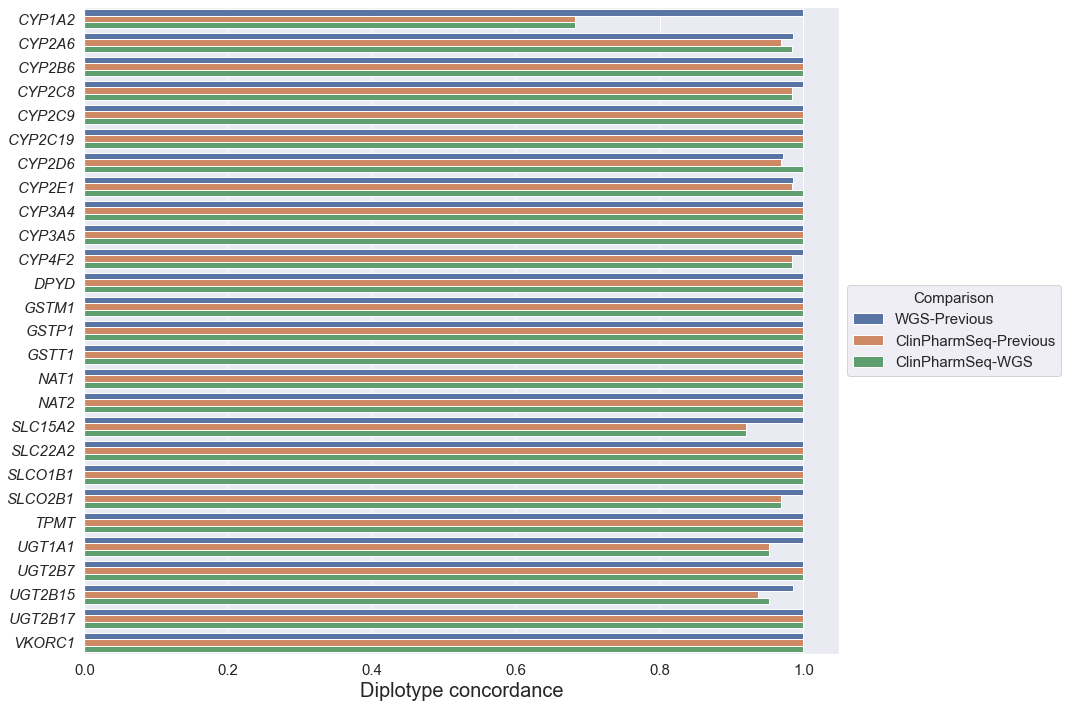

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

sns.set()

df = pd.read_table('other-files/diplotype-concordance.tsv')
df['WGS-Previous'] = df['WGS-Previous'] / 70
df['ClinPharmSeq-Previous'] = df['ClinPharmSeq-Previous'] / 63
df['ClinPharmSeq-WGS'] = df['ClinPharmSeq-WGS'] / 63
df = df.melt(id_vars=['Gene'])

fig, ax = plt.subplots(figsize=(15, 10))

sns.barplot(x='value', y='Gene', hue='variable', data=df, ax=ax)

ax.set_xlabel('Diplotype concordance', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=15)

h, l = ax.get_legend_handles_labels()
ax.legend(h, l, title='Comparison', loc='center left', bbox_to_anchor=(1, 0.5), fontsize=15, title_fontsize=15)

for yticklabel in ax.get_yticklabels():
    yticklabel.set_fontstyle('italic')

ax.set_ylabel('')
    
plt.tight_layout()
plt.savefig('output-files/Figure3_DiplotypeConcordance.png')

# Figure5_Phenotypes

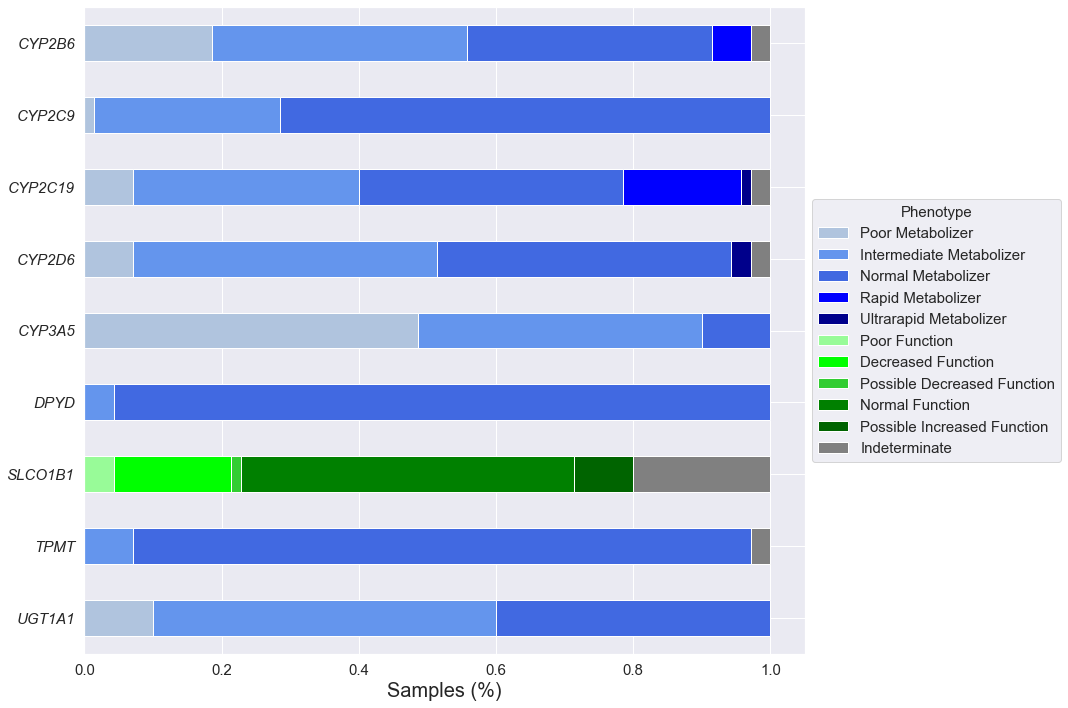

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

sns.set()

fig, ax = plt.subplots(figsize=(15, 10))

df = pd.read_csv('other-files/wgs-phenotypes.csv')
genes = list(reversed(df.columns[1:]))
df = df.melt(id_vars='Sample', var_name='Gene', value_name='Phenotype')
s = df.groupby('Gene')['Phenotype'].value_counts()
s = s / 70
s.name = 'Count'
df = s.to_frame().reset_index()
df = df.pivot(index='Gene', columns='Phenotype', values='Count')
df = df.loc[genes] 
cols = [
    'Poor Metabolizer', 'Intermediate Metabolizer', 
    'Normal Metabolizer', 'Rapid Metabolizer', 
    'Ultrarapid Metabolizer', 'Poor Function', 
    'Decreased Function', 'Possible Decreased Function',
    'Normal Function', 'Possible Increased Function',
    'Indeterminate'
]
df = df[cols]

color = [
    'lightsteelblue', 'cornflowerblue',
    'royalblue', 'blue',
    'darkblue', 'palegreen',
    'lime', 'limegreen',
    'green', 'darkgreen',
    'gray'
]

df.plot.barh(stacked=True, ax=ax, color=color)

h, l = ax.get_legend_handles_labels()
ax.legend(h, l, title='Phenotype', loc='center left', bbox_to_anchor=(1, 0.5), fontsize=15, title_fontsize=15)
ax.set_xlabel('Samples (%)', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=15)

for yticklabel in ax.get_yticklabels():
    yticklabel.set_fontstyle('italic')

ax.set_ylabel('')
    
plt.tight_layout()
plt.savefig('output-files/Figure5_Phenotypes.png')

# Supplementary information

## FigureS2_Uniformity

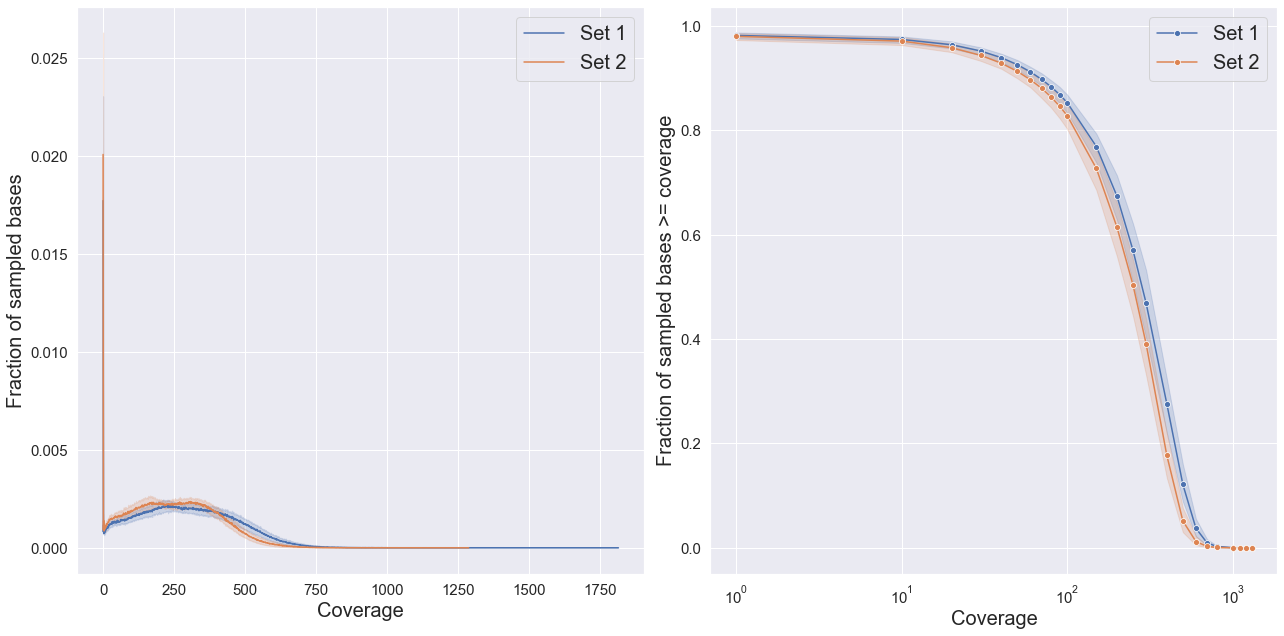

In [6]:
from fuc import pycov
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

cf1 = pycov.CovFrame.from_file('other-files/set1-depth.tsv')
cf2 = pycov.CovFrame.from_file('other-files/set2-depth.tsv')

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(18, 9))

cf1.plot_distribution(ax=ax1)
cf2.plot_distribution(ax=ax1)
ax1.yaxis.label.set_size(20)
ax1.legend(['Set 1', 'Set 2'], fontsize=20)

l = [1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 150, 200, 250, 300, 400, 500, 600, 700, 800, 1000, 1100, 1200, 1300]

cf1.plot_uniformity(ax=ax2, marker='o', n=l)
cf2.plot_uniformity(ax=ax2, marker='o', n=l)
ax2.set_xscale('log')
ax2.legend(['Set 1', 'Set 2'], fontsize=20)
ax2.yaxis.label.set_size(20)

for ax in [ax1, ax2]:
    ax.xaxis.label.set_size(20)
    ax.tick_params(axis='both', which='major', labelsize=15)
    
plt.tight_layout()
plt.savefig('output-files/FigureS2_Uniformity.png')

In [7]:
import pandas as pd

df1 = cf1.matrix_uniformity(n=l)
df2 = cf2.matrix_uniformity(n=l)
df = pd.concat([df1, df2], axis=1)
print(df1.mean(axis=1)[30]) # 0.9519118072303984
print(df2.mean(axis=1)[30]) # 0.9436585542183502
print(df.mean(axis=1)[30])  # 0.947785180724374

0.9521763640055124
0.9433063072209096
0.9477413356132112


## FigureS3_PhenotypeConcordance

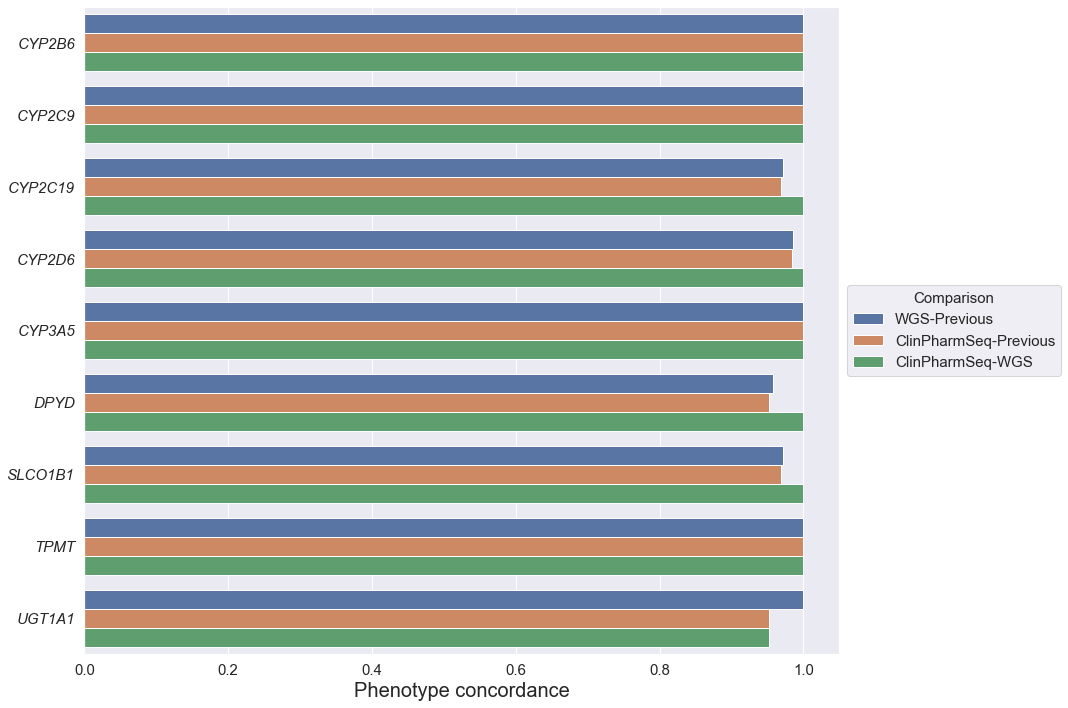

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

sns.set()

df = pd.read_table('other-files/phenotype-concordance.tsv')
df['WGS-Previous'] = df['WGS-Previous'] / 70
df['ClinPharmSeq-Previous'] = df['ClinPharmSeq-Previous'] / 63
df['ClinPharmSeq-WGS'] = df['ClinPharmSeq-WGS'] / 63
df = df.melt(id_vars=['Gene'])

fig, ax = plt.subplots(figsize=(15, 10))

sns.barplot(x='value', y='Gene', hue='variable', data=df, ax=ax)

ax.set_xlabel('Phenotype concordance', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=15)

h, l = ax.get_legend_handles_labels()
ax.legend(h, l, title='Comparison', loc='center left', bbox_to_anchor=(1, 0.5), fontsize=15, title_fontsize=15)

for yticklabel in ax.get_yticklabels():
    yticklabel.set_fontstyle('italic')

ax.set_ylabel('')
    
plt.tight_layout()
plt.savefig('output-files/FigureS3_PhenotypeConcordance.png')

## Panel performance

In [11]:
import pandas as pd
df1 = pd.read_table('other-files/ts1-bedcov.txt', header=None)
df2 = pd.read_table('other-files/ts2-bedcov.txt', header=None)
total = (df1[2] - df1[1]).sum()
cov1 = round(df1.iloc[:, 4:].sum().sum() / 32 / total)
cov2 = round(df2.iloc[:, 4:].sum().sum() / 32 / total)
print(cov1, cov2) # 292 255
df = pd.concat([df1.iloc[:, 4:], df2.iloc[:, 4:]], axis=1)
cov = round(df.sum().sum() / 64 / total)
print(cov)

292 255
274


## Incorrect sample

In [10]:
from fuc import pyvcf, common

# Read the TS VCF
vf1 = pyvcf.VcfFrame.from_file('other-files/ts.merged.joint.filtered.vcf')
vf1.df = vf1.subset('TS2_NA18973').df
vf1 = vf1.update_chr_prefix(mode='remove')

# Read the WGS VCF
vf2 = pyvcf.VcfFrame.from_file('other-files/wgs.merged.joint.filtered.vcf')
vf2.df = vf2.subset('11a1c7b37a63449f9bc65799567b5710').df

# Read the 1KGP VCF
vf3 = pyvcf.VcfFrame.from_file('other-files/1kgp-sliced.vcf')
vf3.df = vf3.subset(['NA18972', 'NA18973']).df
vf3.df = vf3.df[~vf3.df.ALT.str.contains('>')] # Remove SV records (e.g. <CN0>,<CN2>)

# First, calculate the genotype concordance between TS and WGS for NA18973.
vf = pyvcf.merge([vf1, vf2])
vf = vf.filter_multialt()
vf = vf.unphase()
results = common.sumstat(*vf.calculate_concordance('TS2_NA18973', '11a1c7b37a63449f9bc65799567b5710', mode='all'))
print(results)
# {'tpr': 0.532185628742515, 'tnr': 0.8794536817102138, 'ppv': 0.6775730622617535, 'npv': 0.7979525862068966, 'fnr': 0.46781437125748504, 'fpr': 0.12054631828978622, 'fdr': 0.3224269377382465, 'for': 0.20204741379310345, 'acc': 0.7674605728999034}

# Second, calculate the genotype concordance between TS and NA18972 from 1KGP.
vf = pyvcf.merge([vf1, vf3])
vf = vf.filter_multialt()
vf = vf.unphase()
results = common.sumstat(*vf.calculate_concordance('TS2_NA18973', 'NA18972', mode='all'))
print(results)
# {'tpr': 0.8606060606060606, 'tnr': 0.9943181818181818, 'ppv': 0.9861111111111112, 'npv': 0.938337801608579, 'fnr': 0.1393939393939394, 'fpr': 0.005681818181818182, 'fdr': 0.013888888888888888, 'for': 0.06166219839142091, 'acc': 0.9516441005802708}

# Finally, calculate the genotype concordance between TS and NA18973 from 1KGP.
vf = pyvcf.merge([vf1, vf3])
vf = vf.filter_multialt()
vf = vf.unphase()
results = common.sumstat(*vf.calculate_concordance('TS2_NA18973', 'NA18973', mode='all'))
print(results)
# {'tpr': 0.6923076923076923, 'tnr': 0.8425, 'ppv': 0.5625, 'npv': 0.903485254691689, 'fnr': 0.3076923076923077, 'fpr': 0.1575, 'fdr': 0.4375, 'for': 0.09651474530831099, 'acc': 0.8085106382978723}

{'tpr': 0.532185628742515, 'tnr': 0.8794536817102138, 'ppv': 0.6775730622617535, 'npv': 0.7979525862068966, 'fnr': 0.46781437125748504, 'fpr': 0.12054631828978622, 'fdr': 0.3224269377382465, 'for': 0.20204741379310345, 'acc': 0.7674605728999034}
{'tpr': 0.8606060606060606, 'tnr': 0.9943181818181818, 'ppv': 0.9861111111111112, 'npv': 0.938337801608579, 'fnr': 0.1393939393939394, 'fpr': 0.005681818181818182, 'fdr': 0.013888888888888888, 'for': 0.06166219839142091, 'acc': 0.9516441005802708}
{'tpr': 0.6923076923076923, 'tnr': 0.8425, 'ppv': 0.5625, 'npv': 0.903485254691689, 'fnr': 0.3076923076923077, 'fpr': 0.1575, 'fdr': 0.4375, 'for': 0.09651474530831099, 'acc': 0.8085106382978723}
